# Выбор локации для скважины - Машинное обучение в бизнесе

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

- 	id — уникальный идентификатор скважины;
-	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
-	product — объём запасов в скважине (тыс. баррелей).


Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План:
1. Открою файлы и ознакомлюсь с данными. Посмотрю на распределение данных
2. Проверю данные на пропуски и обработаю их
3. Проверю данные на дубли и обработаю их
4. Проверю данные на выбросы и обработаю их
5. Обучу модель и проверю ее на валидационной выборке
6. Подготовлю данные и функцию для расчета прибыли
7. Проведу расчет прибыли и рсиков с использованием процедуры бутстрап
8. Проанализирую полученные данные и обосную выбор региона для разработки

Навыки и инструменты: Pandas,Scikit-learn,бутстреп

## Загрузка и подготовка данных

Подключим все необходимые бибилиотеки

In [ ]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML, display
from tabulate import tabulate
from scipy import stats as st
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

Загрузим датасеты по всем трем регионам и ознакомимся с ними

In [ ]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [ ]:
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [ ]:
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Посмотрим на типы данных в файле и на наличие пропусков в них

In [ ]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датасеты содержат по 100000 значений, в них нет пропусков, все столбцы, кроме id, вещественного типа. Проверим на наличие дубликатов:

In [ ]:
df_0.duplicated().sum()

0

In [ ]:
df_1.duplicated().sum()

0

In [ ]:
df_2.duplicated().sum()

0

In [ ]:
df_0[df_0['id']=='HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Явные дубликаты в датасетах отсутствуют

Проверим на наличие дубликатов по айди и,при наличии, удалим такие точки

In [ ]:
df_0[df_0['id'].duplicated()]['id'].count()

10

In [ ]:
duplicated_id = list(df_0[df_0['id'].duplicated()]['id'])

df_0 = df_0.drop(df_0[df_0['id'].isin(duplicated_id)].index)


In [ ]:
df_0.shape[0]

99980

In [ ]:
df_1[df_1['id'].duplicated()]['id'].count()

4

In [ ]:
duplicated_id = list(df_1[df_1['id'].duplicated()]['id'])

df_1 = df_1.drop(df_1[df_1['id'].isin(duplicated_id)].index)

In [ ]:
df_1.shape[0]

99992

In [ ]:
df_2[df_2['id'].duplicated()]['id'].count()

4

In [ ]:
duplicated_id = list(df_2[df_2['id'].duplicated()]['id'])

df_2 = df_2.drop(df_2[df_2['id'].isin(duplicated_id)].index)

In [ ]:
df_2.shape[0]

99992

Удалено 20, 8 и 8 строк с дублирующимися ID из данных регионов соответственно.

Проверим и удалим выбросы по правилу трех сигм:

In [ ]:
Q1 = df_0.quantile(q=.25)
Q3 = df_0.quantile(q=.75)
IQR = Q3 - Q1
df_0 = df_0[~((df_0<(Q1-1.5*IQR))|(df_0 > (Q3+1.5*IQR))).any(axis=1)]

df_0.shape

/tmp/ipykernel_48/3563096774.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_0 = df_0[~((df_0<(Q1-1.5*IQR))|(df_0 > (Q3+1.5*IQR))).any(axis=1)]
/tmp/ipykernel_48/3563096774.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_0 = df_0[~((df_0<(Q1-1.5*IQR))|(df_0 > (Q3+1.5*IQR))).any(axis=1)]


(99473, 5)

In [ ]:
Q1 = df_1.quantile(q=.25)
Q3 = df_1.quantile(q=.75)
IQR = Q3 - Q1
df_1 = df_1[~((df_1<(Q1-1.5*IQR))|(df_1 > (Q3+1.5*IQR))).any(axis=1)]

df_1.shape

/tmp/ipykernel_48/1620074471.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_1 = df_1[~((df_1<(Q1-1.5*IQR))|(df_1 > (Q3+1.5*IQR))).any(axis=1)]
/tmp/ipykernel_48/1620074471.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_1 = df_1[~((df_1<(Q1-1.5*IQR))|(df_1 > (Q3+1.5*IQR))).any(axis=1)]


(99355, 5)

In [ ]:
Q1 = df_2.quantile(q=.25)
Q3 = df_2.quantile(q=.75)
IQR = Q3 - Q1
df_2 = df_2[~((df_2<(Q1-1.5*IQR))|(df_2 > (Q3+1.5*IQR))).any(axis=1)]

df_2.shape

/tmp/ipykernel_48/1152274535.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_2 = df_2[~((df_2<(Q1-1.5*IQR))|(df_2 > (Q3+1.5*IQR))).any(axis=1)]
/tmp/ipykernel_48/1152274535.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_2 = df_2[~((df_2<(Q1-1.5*IQR))|(df_2 > (Q3+1.5*IQR))).any(axis=1)]


(97996, 5)

Удалены выбросы.

Посмотрим на распределения данных в датасетах по столбцу product

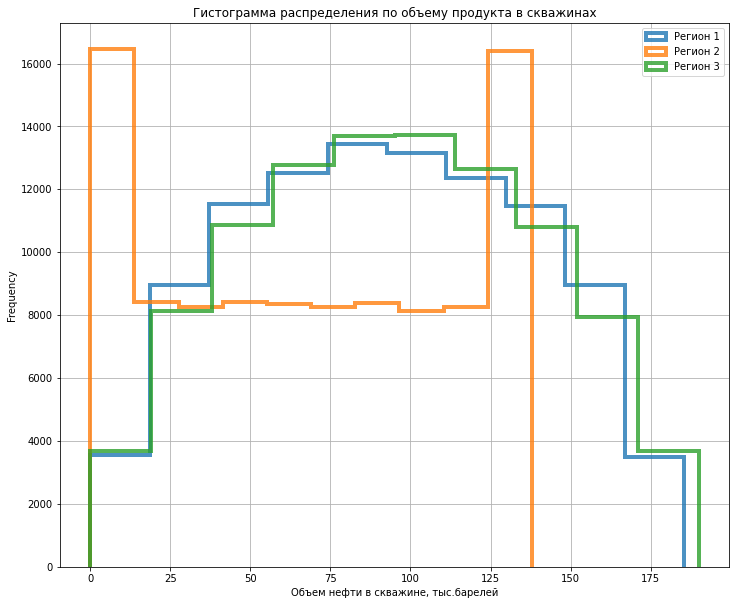

In [ ]:
plt.figure(figsize = [12,10])
plt.title("Гистограмма распределения по объему продукта в скважинах")
plt.ylabel("Количество скважин")
plt.xlabel("Объем нефти в скважине, тыс.барелей")
ax = df_0['product'].plot(kind='hist', grid = True, legend = True,  histtype = 'step', linewidth = 4, alpha=0.8, label = 'Регион 1')
df_1['product'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'Регион 2', ax = ax)
df_2['product'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'Регион 3', ax = ax)
plt.show()

Также оценим распределение значений признаков f0, f1, f2 по районам:

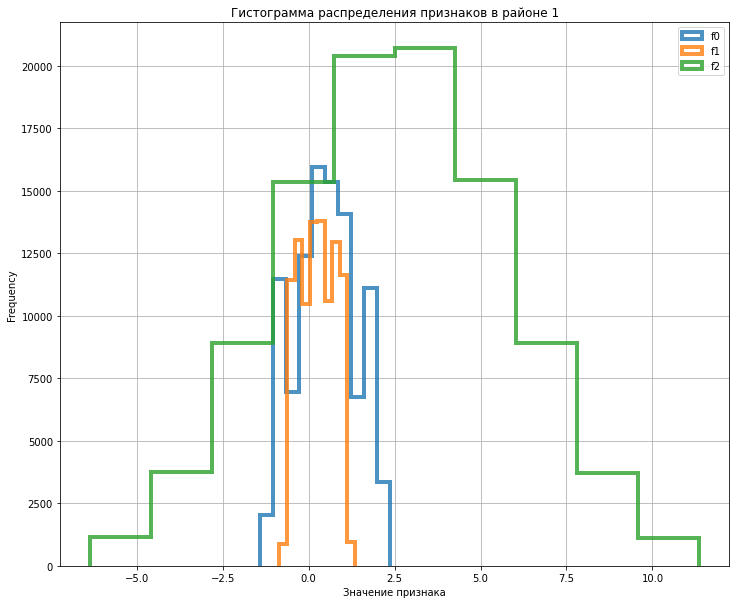

In [ ]:
plt.figure(figsize = [12,10])
plt.title("Гистограмма распределения признаков в районе 1")
plt.ylabel("Количество скважин")
plt.xlabel("Значение признака")
ax = df_0['f0'].plot(kind='hist', grid = True, legend = True,  histtype = 'step', linewidth = 4, alpha=0.8, label = 'f0')
df_0['f1'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f1', ax = ax)
df_0['f2'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f2', ax = ax)
plt.show()

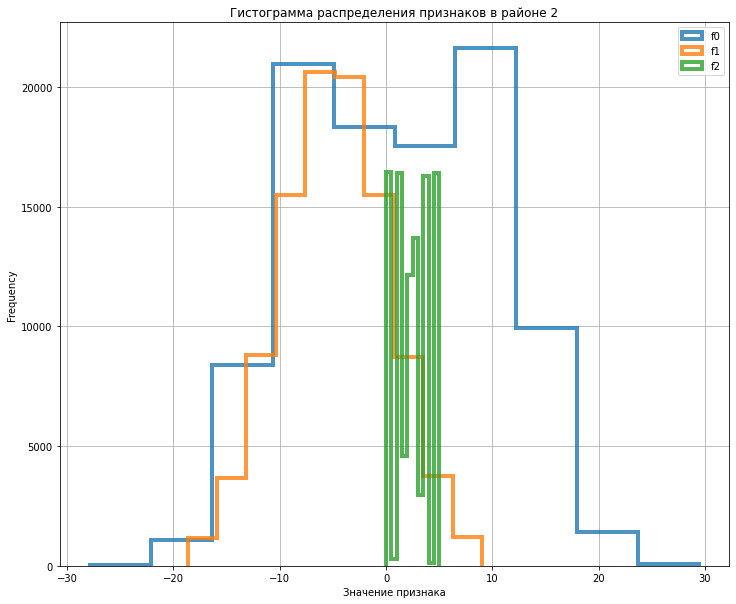

In [ ]:
plt.figure(figsize = [12,10])
plt.title("Гистограмма распределения признаков в районе 2")
plt.ylabel("Количество скважин")
plt.xlabel("Значение признака")
ax = df_1['f0'].plot(kind='hist', grid = True, legend = True,  histtype = 'step', linewidth = 4, alpha=0.8, label = 'f0')
df_1['f1'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f1', ax = ax)
df_1['f2'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f2', ax = ax)
plt.show()

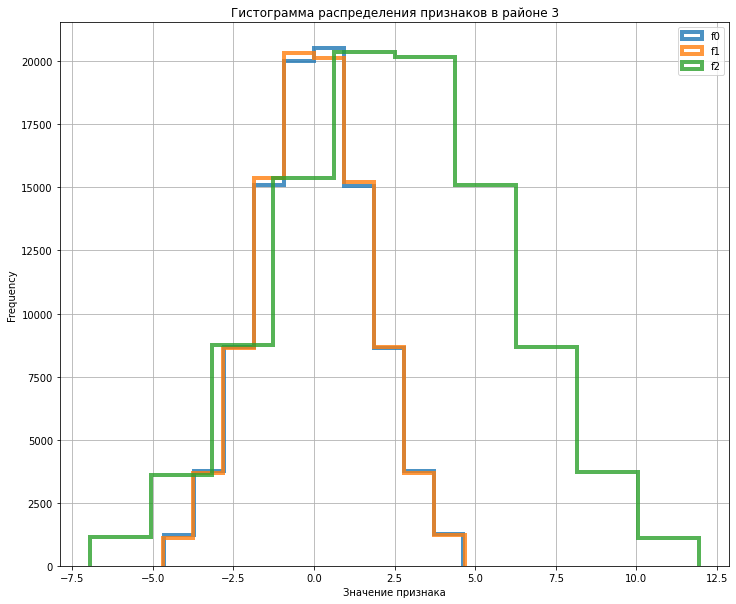

In [ ]:
plt.figure(figsize = [12,10])
plt.title("Гистограмма распределения признаков в районе 3")
plt.ylabel("Количество скважин")
plt.xlabel("Значение признака")
ax = df_2['f0'].plot(kind='hist', grid = True, legend = True,  histtype = 'step', linewidth = 4, alpha=0.8, label = 'f0')
df_2['f1'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f1', ax = ax)
df_2['f2'].plot(kind='hist', grid = True, legend = True, histtype = 'step', linewidth = 4, alpha=0.8, label = 'f2', ax = ax)
plt.show()

Видим, что распределение данных о продукте в 1 и 3 регионе похоже на нормальное, есть нулевые значения, но их менее 4т в датасетах, а во 2 регионе данные распределены не по нормальному закону, наблюдается большое число нулевых значений, а так же 2 конкретных диапазонов -скорее всего данные были внесены искусственно.
Распределение признака f2 во 2 регионе повторяет форму распределения данных о продукте и тоже не выглядит нормальным.

In [ ]:
df_1[df_1['product'] == 0]['product'].count()/df_1.shape[0]*100

8.226058074581049

In [ ]:
df_0[df_0['product'] == 0]['product'].count()/df_0.shape[0]*100

0.0010052979200386035

In [ ]:
df_2[df_2['product'] == 0]['product'].count()/df_2.shape[0]*100

0.001020449814278134

8% нулевых значений во 2 регионе против 0.001% в 1 и 3 регионах.

Посмотрим на матрицы корреляции признаков

In [ ]:
df_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440718,-0.003382,0.143568
f1,-0.440718,1.000000,0.001161,-0.192732
f2,-0.003382,0.001161,1.000000,0.480093
product,0.143568,-0.192732,0.480093,1.000000


In [ ]:
df_1.corr()

,f0,f1,f2,product
f0,1.000000,0.178911,-0.001682,-0.030401
f1,0.178911,1.000000,-0.002780,-0.010199
f2,-0.001682,-0.002780,1.000000,0.999397
product,-0.030401,-0.010199,0.999397,1.000000


In [ ]:
df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000601,0.000455,-0.002943
f1,0.000601,1.000000,0.000739,-0.000951
f2,0.000455,0.000739,1.000000,0.441192
product,-0.002943,-0.000951,0.441192,1.000000


<AxesSubplot:>

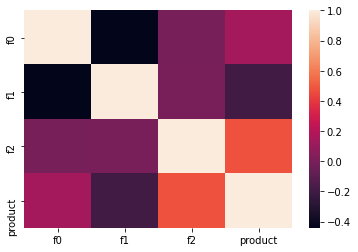

In [ ]:
sns.heatmap(df_0.corr())

<AxesSubplot:>

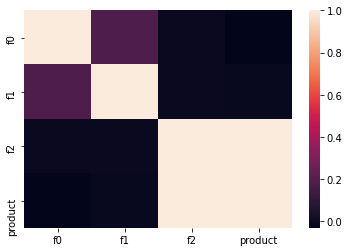

In [ ]:
sns.heatmap(df_1.corr())

<AxesSubplot:>

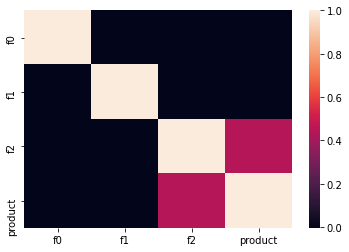

In [ ]:
sns.heatmap(df_2.corr())

Во втором регионе корреляция признака f2  с целевым близка к 1, что скорее всего также является следствием искусственно введенных данных, это даст нам крайне точные прогнозы в модели, однако является непонятным, можем ли мы считать подобнеы данные достоверными и реомендовать такой регион. В регионах 1 и 3 тоже наблюдается корреляция с силой близкой к 0.5, но не такая прямолинейная.

**Вывод**

    Данные из файлов со всех трех регионов были загружены, изучены на тип данных, наличие дубликатов и пропусков,изучено распределение данных, корреляция признаков.

    Сделан вывод о наличии большого процента нулевых значений целевого признака в данных второго региона в сравнении с двумя другими, о несоответствии рапсределения данных целевого признака во втором регионе нормальному, о наличии сильнейшей корреляции между признаком f2 и целевым во втором регионе, сделано предположение об искусственной природе данных второго региона. также определено наличи довольно заметной корреляции между признаком f2 и целевым в двух других регионах.

## Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки в соотношении 75% к 25%, отмашстабируем признаки и обучим модель линейной регрессии. Для удобства применения данной операции на каждом из 3 датасетов опишем эти операции в функции.

In [ ]:
def make_linear_model(df):
    #удалим незначащий для модели столбец с ИД скважин, разделим датасет на целевой признак и прочие.
    target = df['product']
    features = df.drop(['id', 'product'], axis = 1)

    #делим выборку на обучающую и валидационную в соотношении 75-25
    features_train, features_valid, target_train, target_valid = train_test_split(features,target, test_size=0.25,
                                                                                  random_state=12345)
    #отмасштабируем численные признаки (в нашем случае все)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_s = scaler.transform(features_train)
    features_valid_s = scaler.transform(features_valid)

    #создадим модель линейной регрессии, обучим ее и предскажем знаечния на валидационной выборке
    model = LinearRegression()
    model.fit(features_train_s, target_train)
    target_predicted = model.predict(features_valid_s)

    #вычислим RMSE, r2 и средний запас предсказанный запас сырья
    rmse = mean_squared_error(target_valid, target_predicted)**0.5
    r2 = r2_score (target_valid, target_predicted)
    predicted_target_sum = target_predicted.sum()
    predicted_target_mean = round(predicted_target_sum/len(target_predicted),2)

    #вернем предсказанные значения на валидационной выборке в виде Series, верные значения,
    #знаечние RMSE и средний предсказанный запас
    return pd.Series(target_predicted), target_valid, rmse, r2, predicted_target_mean, predicted_target_sum

Получим и выведем на экран соответствующие значения для каждого из регионов:

In [ ]:
predicted_target_0, target_valid_0, rmse_0, r2_0, predicted_target_mean_0, predicted_target_sum_0 = make_linear_model(df_0)
predicted_target_1, target_valid_1, rmse_1, r2_1, predicted_target_mean_1, predicted_target_sum_1 = make_linear_model(df_1)
predicted_target_2, target_valid_2, rmse_2, r2_2, predicted_target_mean_2, predicted_target_sum_2 = make_linear_model(df_2)

In [ ]:
 table = [['Регион', 'Предсказанный ср.запас, тыс.баррелей','Предсказанный суммарный запас, тыс.баррелей',  'RMSE', 'R2'],
          [1, predicted_target_mean_0, predicted_target_sum_0, rmse_0, r2_0],
          [2, predicted_target_mean_1, predicted_target_sum_1, rmse_1, r2_1],
          [3,predicted_target_mean_2, predicted_target_sum_2, rmse_2, r2_2]]
display(HTML(tabulate(table, tablefmt='html')))

Регион,"Предсказанный ср.запас, тыс.баррелей","Предсказанный суммарный запас, тыс.баррелей",RMSE,R2
1,92.59,2302701.1395925004,37.723754923964115,0.2745428314315571
2,68.64,1704916.1785340065,0.8892698446231985,0.9996259917954178
3,94.66,2319144.625787046,40.26728172753466,0.19320716246439573


<AxesSubplot:>

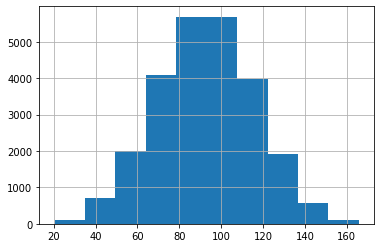

In [ ]:
predicted_target_0.hist()

<AxesSubplot:>

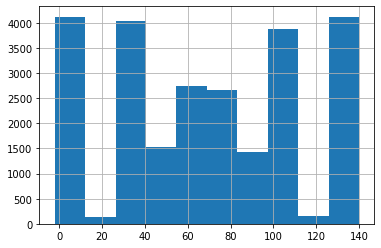

In [ ]:
predicted_target_1.hist()

<AxesSubplot:>

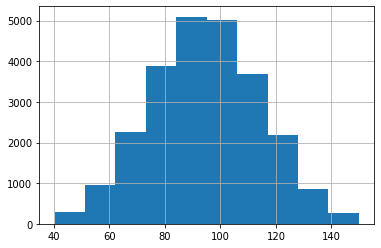

In [ ]:
predicted_target_2.hist()

Показатели второго региона, конечно, впечатляют - минимальное r2 = 0.89 и r2 практическо равное 1, выглядит, как идеальная модель, однако, вспомнив количество нулевых значений, вид распределения, максимальную корреляюцию между признаком f2 и целевым и выводы об искуственной природе данных скорее можем сделать вывод,что модель переобучилась и можно рекомендовтаь этот регион только в том случае, если в рамках задачи мы считаем данные 2 региона истинными. В противном случае выбор придется делать из 1 и 3 регионов.
1 и 3 регион близки по среднему предсказанному запасу сырья, RMSE чуть меньше у первого региона - 37.58 против 40 у третьего. Однако цифра в обоих регионах очень велика.

**Вывод**

    Данные были разбиты на обучающую и валидационную выборки, отмасштабированы, построена модель линейной регрессии и получены предсказания для каждого из регионов.
    По полученным предсказаниям вычислены и сравнены значения RMSE и R2 для всех трех регионов, рассмотрено распределение прогнозируемых значений на регионах, был сделан вывод о высочайших показателях второго региона, указана необходимость исключения из рассмотрения данных второго региона как возможного региона для разработки в случае, если мы не считаем, что синтетические данные второго региона истинны.

## Подготовка к расчёту прибыли

Исходные условия задачи:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
-  Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.
- Среди них выбирают регион с наибольшей средней прибылью.

Внесем соответствующие константы в тысячах рублей

In [ ]:
BUDGHET = 10000000 #тыс руб
INCOME_PER_WELL = 450  #тыс руб
LOOSE_POSSIBILITY = 2.5 / 100
WELL_COUNT = 500 #шт
WELL_BEST_COUNT  = 200  #шт

Подсчитаем безубыточную разработку сырья на нужном нам количестве месторождений (200). Разделим выделенный бюджет на заданное количество скважин для разработки:

In [ ]:
budghet_per_well = BUDGHET / WELL_BEST_COUNT
budghet_per_well

50000.0

Имеем 50000 тыс.руб на одну скважину. Подсчитаем, сколько нефти нам нужно иметь на данной скважине, учитывая ее доход с единицы продукта:

In [ ]:
product_per_well = budghet_per_well / INCOME_PER_WELL
product_per_well

111.11111111111111

Для безубыточной разработки требуется запас в 111.11 тыс. баррелей на скважине. Подсчитаем общий необходимый запас на регионе:

In [ ]:
product_per_region =  product_per_well * WELL_BEST_COUNT
product_per_region

22222.222222222223

На регионе суммарно должно быть 22 222.22 тыс. баррелей нефти для безубыточной разработки региона.
Средний предсказанный запас нефти на всех регионах ниже необходимого : 92.59, 68.73 и 94.97 соответственно. Однако выбор лучших 200 скважин сможет улучшить ситуацию.

Напишем функцию расчета прибыли с отбором нужного числа лучших скважин, умножением их на доходность одной скважины и отнимаем расходы (бюджет на разработку)

In [ ]:
def profit_calculation(target, probabilities, best_count):
    probabilities_sorted = probabilities.sort_values(ascending=False)
    selected_probabilities = target[probabilities_sorted.index][:best_count]
    return INCOME_PER_WELL * selected_probabilities.sum() - BUDGHET

**Вывод**

    Были заведены все необходимые Python константы для дальнейших расчетов, проанализирован необходимый запас нефти на скважине и на регионе для безубыточной разработки, написана функция расчета прибыли.

## Расчёт прибыли и рисков

При помощи технологии Bootstrap на 1000 выборок посмотрим распределение прибыли

In [ ]:
def bootstrap_check(target, predictions):
    state = np.random.RandomState(12345)
    bootstrap_samples = 1000 #количество проб
    profits = [] #подсчитанная выручка

    for i in range(bootstrap_samples):
        target_sample = target.reset_index(drop=True).sample(n = WELL_COUNT, replace = True, random_state = state)
        predictions_sample = predictions[target_sample.index]
        profit = profit_calculation(target_sample, predictions_sample, WELL_BEST_COUNT)
        profits.append(profit)

    profits = pd.Series(profits)

    lower = profits.quantile(LOOSE_POSSIBILITY)
    upper = profits.quantile(1 - LOOSE_POSSIBILITY)
    profit_mean = profits.mean()

    print(f'Средняя прибыль: {profit_mean} тыс. руб')
    print(f'2.5%-квантиль: {lower} тыс. руб')
    print(f'97.5%-квантиль: {upper} тыс. руб')
    print(f'95% доверительный интервал: от  {lower} тыс. руб до {upper} тыс. руб')
    print(f'Риск убытков: {(profits < 0).mean() * 100} %')

Рассчитаем прибыль и риск убытков на каждом из трех регионов:

In [ ]:
bootstrap_check(target_valid_0, predicted_target_0)

Средняя прибыль: 406605.82526948 тыс. руб
2.5%-квантиль: -93101.51878182334 тыс. руб
97.5%-квантиль: 908031.3043597329 тыс. руб
95% доверительный интервал: от  -93101.51878182334 тыс. руб до 908031.3043597329 тыс. руб
Риск убытков: 6.7 %


In [ ]:
bootstrap_check(target_valid_1, predicted_target_1)

Средняя прибыль: 500710.183973134 тыс. руб
2.5%-квантиль: 63836.59388120626 тыс. руб
97.5%-квантиль: 935147.4066005903 тыс. руб
95% доверительный интервал: от  63836.59388120626 тыс. руб до 935147.4066005903 тыс. руб
Риск убытков: 1.2 %


In [ ]:
bootstrap_check(target_valid_2, predicted_target_2)

Средняя прибыль: 341258.2117479128 тыс. руб
2.5%-квантиль: -201815.93287134383 тыс. руб
97.5%-квантиль: 878895.3184961762 тыс. руб
95% доверительный интервал: от  -201815.93287134383 тыс. руб до 878895.3184961762 тыс. руб
Риск убытков: 11.200000000000001 %


**Вывод**

    Поставленному бизнесом условию о непривышении 2.5% рисков на регионе выполняется только для второго региона, да и показатели прибыли и доверительного интервала там просто поражают воображение, однако согласно ранее сделанным выводам мы считаем его синтетическим, модель переобученной и можем ссылаться на данные этого региона, распределение которых имеет явно искуственную природу, только если игнорируем данный факт в рамках учебной задачи.

    В противном случае, с исключением из рассмотрения второго региона,наиболее привлекательным для разработки выглядит первый регион, т.к. в сравнении с третьим регионом  снижение средней прибыли не так велико, как хорошо выглядит снижение риска убытков на 0.4% и более узкие рамки 95% доверительного интервала. Однако требуемого урвоня рсиков -2.5% не показывает ни один из них.

## Общий вывод

- Данные из файлов со всех трех регионов были загружены
- Файлы изучены на тип данных, наличие дубликатов и пропусков,изучено распределение данных, корреляцию признаков.
- Сделаны выводы:
    - о наличии большого процента нулевых значений целевого признака в данных второго региона в сравнении с двумя другими
    - о несоответствии рапсределения данных целевого признака во втором регионе нормальному
    - о наличии сильнейшей корреляции между признаком f2 и целевым во втором регионе, доовльно заметной корреляции между тем же признаком и целевым в двух других регионах
    - о предположительно искусственной природе данных второго региона.
    
- Данные были разбиты на обучающую и валидационную выборки
- Признаки были отмасштабированы
- Была построена модель линейной регрессии и получены предсказания для каждого из регионов
- По полученным предсказаниям вычислены и сравнены значения RMSE и R2 для всех трех регионов
- Рассмотрено распределение прогнозируемых значений на регионах
- Был сделан вывод о необходимости исключения из рассмотрения данных второго региона как возможного региона для разработки.
- Были заведены все необходимые Python константы для дальнейших расчетов
- Были проанализирован необходимый запас нефти на скважине и на регионе для безубыточной разработки
- Была написана функция расчета прибыли.

- Была проведена процедура проверки распределения прибыли на 1000 выборок при помощи Bootstrap на каждом регионе
- Был оценен 95% доверительный интервал распределения прибыли на каждом регионе
- Был оценен риск убытков на каждом из регионов
- В результате анализа полученных результатов сделан вывод по рекомендуемому региону для разработки:
    - Поставленному бизнесом условию о непривышении 2.5% рсиков на регионе выполняется только для второго региона, да и показатели прибыли и доверительного интервала там просто поражают воображение, однако согласно ранее сделанным выводам мы считаем его синтетическим, модель переобученной и не можем ссылаться на данные этого региона, распределение которых имеет явно искуственную природу.
    - Таким образом, в соответствии с исключением из рассмотрения второго региона,наиболее привлекательным для разработки выглядит первый регион, т.к. в сравнении с третьим регионом  снижение средней прибыли не так велико, как хорошо выглядит снижение риска убытков на 0.4% и более узкие рамки 95% доверительного интервала. Однако требуемого урвоня рсиков -2.5% не показывает ни один из них.


## Чек лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован